Running Hill Climbing...
Hill Climbing Best Distance: 885.36
Running Genetic Algorithm...
Genetic Algorithm Best Distance: 819.49


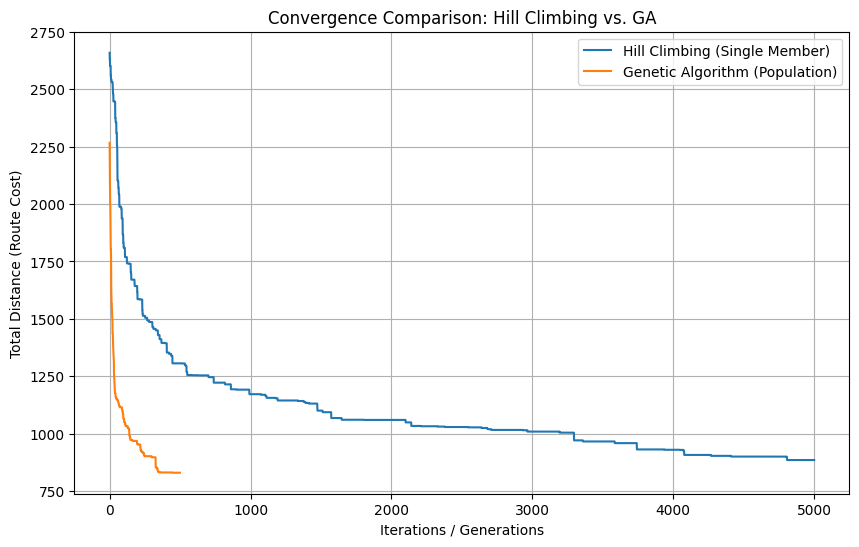

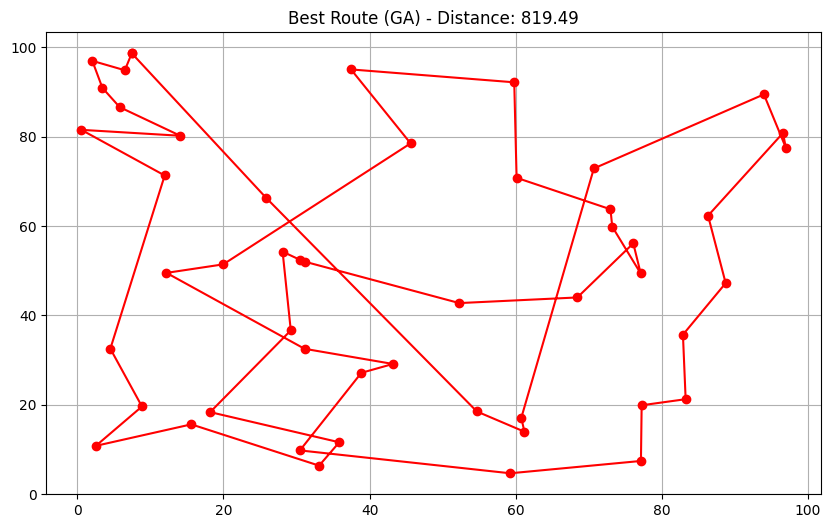

In [15]:
from numpy.matrixlib.defmatrix import matrix
from typing import Self
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# loading csv file
df = pd.read_csv("cities.csv")

# set this seed for reproducibility
random.seed(42)
np.random.seed(42)

class TSPsolve:

    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)
        self.cities = self.data["City"].tolist()
        self.coords = self.data[["X", "Y"]].values
        self.num_cities = len(self.cities)
        self.dist_matrix = self._compute_distance_matrix()

    def _compute_distance_matrix(self):
        matrix = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(self.num_cities):
                # Corrected: lowercase 'self' and fixed nested loops
                matrix[i,j] = np.linalg.norm(self.coords[i] - self.coords[j])
        return matrix

    def calculate_total_distance(self, tour):
        distance = 0
        for i in range(len(tour)):
            distance += self.dist_matrix[tour[i], tour[(i + 1) % len(tour)]]
        return distance

    # Single member search: hill climbing
    def hill_climbing(self, max_iteration = 5000):
        current_tour = list(range(self.num_cities))
        random.shuffle(current_tour)
        current_dist = self.calculate_total_distance(current_tour)

        history = [current_dist]

        for _ in range(max_iteration):
            a,b = random.sample(range(self.num_cities), 2)
            neighbor = current_tour.copy()
            neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
            neighbor_dist = self.calculate_total_distance(neighbor)

            # accept if neighbor is better
            if neighbor_dist < current_dist:
                current_tour = neighbor
                current_dist = neighbor_dist

            history.append(current_dist)

        return current_tour, current_dist, history

    # population based : genetic algorithm
    def genetic_algorithm(self, pop_size=100, generation=500, mutation_rate=0.05):

        def create_pop():
            pop = []
            for _ in range(pop_size):
                sol = list(range(self.num_cities))
                random.shuffle(sol)
                pop.append(sol)
            return pop

        def crossover(p1, p2):
            size = len(p1)
            a,b = sorted(random.sample(range(size),2))
            child = [None] * size
            child[a:b] = p1[a:b]
            p2_ptr = 0
            for i in range(size):
                if child[i] is None:
                    while p2[p2_ptr] in child:
                        p2_ptr += 1
                    child[i] = p2[p2_ptr]
            return child

        def mutate(individual):
            if random.random() < mutation_rate:
                a,b = random.sample(range(len(individual)), 2)
                individual[a], individual[b] = individual[b], individual[a]
            return individual

        population = create_pop()
        history = []

        for gen in range(generation):
            fitness_scores = [1/self.calculate_total_distance(ind) for ind in population]
            best_dist = 1 / max(fitness_scores)
            history.append(best_dist)

            new_population = []
            # Corrected: use parentheses for argmax and copy the individual
            best_ind = population[np.argmax(fitness_scores)]
            new_population.append(list(best_ind))

            while len(new_population) < pop_size:
                parents = []
                for _ in range(2):
                    candidates = random.sample(list(zip(population, fitness_scores)), 3)
                    parents.append(max(candidates, key=lambda x: x[1])[0])

                # crossover mutation
                offspring = crossover(parents[0], parents[1])
                offspring = mutate(offspring)
                new_population.append(offspring)

            population = new_population

        final_best = min(population, key=self.calculate_total_distance)
        return final_best, self.calculate_total_distance(final_best), history

    def plot_comparison(self, hc_hist, ga_hist):
        plt.figure(figsize=(10, 6))
        plt.plot(hc_hist, label='Hill Climbing (Single Member)')
        plt.plot(ga_hist, label='Genetic Algorithm (Population)')
        plt.xlabel('Iterations / Generations')
        plt.ylabel('Total Distance (Route Cost)')
        plt.title('Convergence Comparison: Hill Climbing vs. GA')
        plt.legend()
        plt.grid(True)
        plt.savefig("performance_comparison.png")
        plt.show()

    def plot_route(self, tour, title):
        plt.figure(figsize=(10,6))
        # Corrected: close the loop for the route
        route_coords = self.coords[tour + [tour[0]]]
        plt.plot(route_coords[:, 0], route_coords[:, 1], 'o-r')
        plt.title(title)
        plt.grid(True)
        plt.show()

# Code for running properly
solver = TSPsolve("cities.csv")

print("Running Hill Climbing...")
hc_tour, hc_dist, hc_history = solver.hill_climbing(max_iteration=5000)
print(f"Hill Climbing Best Distance: {hc_dist:.2f}")

print("Running Genetic Algorithm...")
ga_tour, ga_dist, ga_history = solver.genetic_algorithm(pop_size=100, generation=500)
print(f"Genetic Algorithm Best Distance: {ga_dist:.2f}")

solver.plot_comparison(hc_history, ga_history)
solver.plot_route(ga_tour, f"Best Route (GA) - Distance: {ga_dist:.2f}")
